In [1]:
import os
import pickle
import argparse
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from operator import itemgetter
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import spearmanr

In [2]:
data_dir = 'data'
wsd_dir = 'WS353'
lan_to_file = {'de': 'German', 'en': 'English', 'it': 'Italian'}

In [3]:
def CommonPairsOfWords(sim_ds, word2idx):
    # --- Check for common words between the similarity dataset and the embeddings ---
    # Words in the similarity dataset
    sim_words = set(sim_ds.Word1.values).union(set(sim_ds.Word2.values))
    # Embedded words
    train_words = set(word2idx.keys())
    # Words in common
    common_words = [w for w in sim_words if w in train_words]
    print(f"There are {len(common_words)} words in common out of {len(sim_words)} in the word similarity dataset.")
    
    # --- Check for common pairs of words ---
    # Pairs of words in the word similarity dataset
    pair_of_words = sim_ds[['Word1', 'Word2']].values

    # Construction of necessary data structures
    ## Common pairs of words, where words are converted into indices wrt our embedding model.
    common_pairs_idx = []
    ## List of indice of the common pairs of words wrt the word similarity dataset
    common_is = []

    for i, pair in enumerate(pair_of_words):
        if pair[0] in common_words and pair[1] in common_words:
            common_pairs_idx.append([word2idx[pair[0]], word2idx[pair[1]]])
            common_is.append(i)
    print(f'There are {len(common_pairs_idx)} common pairs of words, out of {len(pair_of_words)} in the word similarity dataset.')
    
    return common_pairs_idx, common_is

def ComputeEmbeddingSimilarity(common_pairs_idx, idx2vec):
    # List of cosine similarity scores of common pairs of words
    train_score = []
    for pair in common_pairs_idx:
        val = cosine_similarity(idx2vec[pair[0]].reshape(1,-1), idx2vec[pair[1]].reshape(1,-1)).item()
        train_score.append(max(0,val))
    train_score = np.array(train_score).reshape(-1,1)
    return train_score


def ComputeSimilarityStats(common_sim, train_score, train_score_ngrams):
    
    # Let rescale cosine similarity to get values comparable with the average score in sim_ds
    common_sim.loc[:,'base'] = np.round(train_score * 10, 2)
    common_sim.loc[:,'ngram'] = np.round(train_score_ngrams * 10, 2)
    
    means = common_sim.mean(axis=0)[['Average Score', 'base', 'ngram']]
    print('Means of similarity scores:')
    print(means)
    print('')

    # Let compute how much each rescaled cosine similarity differs from the human similarity score, for both embedding approach
    common_sim.loc[:, 'bdiff'] = np.abs(common_sim['Average Score']  - common_sim['base'])
    common_sim.loc[:, 'bdiff_v2'] = np.abs(common_sim['Average Score']  - (common_sim['base']+means['ngram']-means['base']))
    
    common_sim.loc[:, 'ngdiff'] = np.abs(common_sim['Average Score'] - common_sim['ngram'])
    
    # Let compute the difference between the performance of the two models
    common_sim.loc[:, 'bngdiff'] = common_sim['bdiff'] - common_sim['ngdiff']
    common_sim.loc[:, 'bngdiff_v2'] = common_sim['bdiff_v2'] - common_sim['ngdiff']
    
    ngram_better = (common_sim['bngdiff'] > 0).sum()
    print(f'''Similarity scores of ngram based approach are closer to the human similarity scores in {ngram_better} case(s) out out of {len(common_sim)} cases. ({100*round(ngram_better/len(common_sim), 3)}%)''')
    
    ngram_equal = (common_sim['bngdiff'] == 0).sum()
    print(f'''Similarity scores of both approaches work equivalently in {ngram_equal} case(s).({100*round(ngram_equal/len(common_sim), 3)}%)''')
    ngram_worse = (common_sim['bngdiff'] < 0).sum()
    print(f'''Similarity scores of ngram based approach underperfor in {ngram_worse} case(s). ({100*round(ngram_worse/len(common_sim), 2)}%)''')
    
    print('')
    print('After adjusting the scores of the base model by adding the difference between the mean of the ngram and the base model scores')
    ngram_better_v2 = (common_sim['bngdiff_v2'] > 0).sum()
    print(f'''Similarity scores of ngram based approach are closer to the human similarity scores in {ngram_better_v2} case(s) out out of {len(common_sim)} cases. ({100*round(ngram_better_v2/len(common_sim), 3)}%)''')
    ngram_equal_v2 = (common_sim['bngdiff_v2'] == 0).sum()
    print(f'''Similarity scores of both approaches work equivalently in {ngram_equal_v2} case(s).({100*round(ngram_equal_v2/len(common_sim), 3)}%)''')
    ngram_worse_v2 = (common_sim['bngdiff_v2'] < 0).sum()
    print(f'''Similarity scores of ngram based approach underperfor in {ngram_worse_v2} case(s). ({100*round(ngram_worse_v2/len(common_sim), 2)}%)''')
    
    pd.set_option('display.max_rows', None)
    
    return (common_sim[['Word1', 'Word2', 'Average Score', 'base', 'ngram', 'bdiff', 'bdiff_v2', 'ngdiff', 'bngdiff', 'bngdiff_v2']],
            {'outperforming': ngram_better, 'downperforming': ngram_worse, 'equivalent': ngram_equal},
            {'outperforming': ngram_better_v2, 'downperforming': ngram_worse_v2, 'equivalent': ngram_equal_v2})

def RelevantPairs(common_sim, worse_threshold, better_threshold):
    much_worse = common_sim[common_sim.bngdiff < -worse_threshold]
    much_better = common_sim[common_sim.bngdiff > better_threshold]
    much_worse_v2 = common_sim[common_sim.bngdiff_v2 < -worse_threshold]
    much_better_v2 = common_sim[common_sim.bngdiff_v2 > better_threshold]
    
    return (much_worse.sort_values('bngdiff'),
            much_better.sort_values('bngdiff', ascending = False),
            much_worse.sort_values('bngdiff_v2'),
            much_better.sort_values('bngdiff_v2', ascending = False))

In [4]:
common_sim = {}
ngram_stats = {}
spearman_scores = {}
ngram_stats_v2 = {}

## English

In [5]:
lan = 'en'

In [6]:
# --- Import word similarity dataset WS353 for the selected language ---
sim_ds = pd.read_csv(os.path.join(wsd_dir, f'MWS353_{lan_to_file[lan]}.txt'), sep=",")
sim_ds.head()

,Word1,Word2,1,2,3,4,5,6,7,8,9,10,11,12,13,Average Score
0,love,sex,9.0,9.0,7.0,7.0,8,10.0,9.0,7.0,10.0,8.0,9.0,8.0,7,8.31
1,tiger,cat,7.0,9.0,9.0,7.0,8,7.0,10.0,7.0,10.0,8.0,9.0,8.0,9,8.31
2,tiger,tiger,10.0,10.0,10.0,10.0,10,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10,10.00
3,book,paper,9.0,8.0,7.0,6.0,6,9.0,8.0,7.0,10.0,5.0,9.0,7.0,9,7.69
4,computer,keyboard,9.0,10.0,5.0,7.0,8,8.0,9.0,10.0,10.0,7.0,9.0,9.0,8,8.38


In [7]:
# --- Import data of our embedding model ---
word2idx = pickle.load(open(os.path.join(data_dir, lan, 'word2idx.dat'), 'rb'))
# Embeddings without subwords' information
idx2vec = pickle.load(open(os.path.join(data_dir, lan, 'idx2vec.dat'), 'rb'))
# Embeddings with subwords' information
idx2vec_ngrams = pickle.load(open(os.path.join(data_dir, lan, 'idx2vec_ngrams.dat'), 'rb'))

In [8]:
# --- Identify common pairs of words ---
common_pairs_idx, common_is = CommonPairsOfWords(sim_ds, word2idx)

There are 335 words in common out of 435 in the word similarity dataset.
There are 229 common pairs of words, out of 350 in the word similarity dataset.


In [9]:
# --- Compute cosine similarity of embeddings without subwords' information for common pairs of words ---
train_score = ComputeEmbeddingSimilarity(common_pairs_idx, idx2vec)

In [10]:
# --- Compute cosine similarity of embeddings with subwords' information for common pairs of words ---
train_score_ngrams = ComputeEmbeddingSimilarity(common_pairs_idx, idx2vec_ngrams)

In [12]:
(cs, ns, ns_v2 ) = ComputeSimilarityStats(sim_ds.iloc[common_is], train_score, train_score_ngrams)
common_sim[lan] = cs
ngram_stats[lan] = ns
ngram_stats_v2[lan] = ns_v2

Means of similarity scores:
Average Score    5.396114
base             1.565983
ngram            5.155066
dtype: float64

Similarity scores of ngram based approach are closer to the human similarity scores in 169 case(s) out out of 229 cases. (73.8%)
Similarity scores of both approaches work equivalently in 0 case(s).(0.0%)
Similarity scores of ngram based approach underperfor in 60 case(s). (26.0%)

After adjusting the scores of the base model by adding the difference between the mean of the ngram and the base model scores
Similarity scores of ngram based approach are closer to the human similarity scores in 82 case(s) out out of 229 cases. (35.8%)
Similarity scores of both approaches work equivalently in 0 case(s).(0.0%)
Similarity scores of ngram based approach underperfor in 147 case(s). (64.0%)


In [13]:
# --- Compute Spearman's rank correlation coefficients
sim_score = common_sim[lan]['Average Score'].values.reshape(-1,1)
ss = {'base': spearmanr(sim_score, train_score),
      'ngram': spearmanr(sim_score, train_score_ngrams)}
spearman_scores[lan] = ss

In [14]:
(much_worse, much_better, much_worse_v2, much_better_v2) = RelevantPairs(common_sim[lan], worse_threshold = 0, better_threshold = 0)

In [15]:
# Pairs of words of worst underperforming cases of ngram based model
much_worse.head(5)

,Word1,Word2,Average Score,base,ngram,bdiff,bdiff_v2,ngdiff,bngdiff,bngdiff_v2
260,profit,warning,0.77,0.87,8.95,0.10,3.689083,8.18,-8.08,-4.490917
323,sugar,approach,1.00,1.50,7.99,0.50,4.089083,6.99,-6.49,-2.900917
215,governor,interview,1.31,1.58,7.41,0.27,3.859083,6.10,-5.83,-2.240917
33,king,cabbage,1.15,1.24,6.34,0.09,3.679083,5.19,-5.10,-1.510917
181,century,nation,1.46,1.39,6.37,0.07,3.519083,4.91,-4.84,-1.390917


In [16]:
# Pairs of words of best outerperforming cases of ngram based model
much_better.head(5)

,Word1,Word2,Average Score,base,ngram,bdiff,bdiff_v2,ngdiff,bngdiff,bngdiff_v2
263,dollar,buck,9.54,0.68,8.47,8.86,5.270917,1.07,7.79,4.200917
197,treatment,recovery,7.54,0.54,7.81,7.00,3.410917,0.27,6.73,3.140917
34,king,queen,8.46,0.09,6.77,8.37,4.780917,1.69,6.68,3.090917
282,seafood,sea,7.94,0.13,6.49,7.81,4.220917,1.45,6.36,2.770917
49,movie,star,7.46,0.00,6.14,7.46,3.870917,1.32,6.14,2.550917


In [17]:
# Pairs of words of worst underperforming cases of ngram based model after rescaling base scores
much_worse_v2.head(5)

,Word1,Word2,Average Score,base,ngram,bdiff,bdiff_v2,ngdiff,bngdiff,bngdiff_v2
178,prejudice,recognition,2.73,0.06,8.51,2.67,0.919083,5.78,-3.11,-4.860917
260,profit,warning,0.77,0.87,8.95,0.10,3.689083,8.18,-8.08,-4.490917
270,luxury,car,5.12,0.47,0.00,4.65,1.060917,5.12,-0.47,-4.059083
212,life,term,5.35,1.22,0.83,4.13,0.540917,4.52,-0.39,-3.979083
315,population,development,4.42,1.06,8.50,3.36,0.229083,4.08,-0.72,-3.850917


In [18]:
# Pairs of words of best outerperforming cases of ngram based model after rescaling base scores
much_better_v2.head(5)

,Word1,Word2,Average Score,base,ngram,bdiff,bdiff_v2,ngdiff,bngdiff,bngdiff_v2
263,dollar,buck,9.54,0.68,8.47,8.86,5.270917,1.07,7.79,4.200917
197,treatment,recovery,7.54,0.54,7.81,7.00,3.410917,0.27,6.73,3.140917
34,king,queen,8.46,0.09,6.77,8.37,4.780917,1.69,6.68,3.090917
282,seafood,sea,7.94,0.13,6.49,7.81,4.220917,1.45,6.36,2.770917
49,movie,star,7.46,0.00,6.14,7.46,3.870917,1.32,6.14,2.550917


## German

In [19]:
lan = 'de'

In [20]:
# --- Import word similarity dataset WS353 for the selected language ---
sim_ds = pd.read_csv(os.path.join(wsd_dir, f'MWS353_{lan_to_file[lan]}.txt'), sep=",")
sim_ds.head()

,Word1,Word2,1,2,3,4,5,6,7,8,9,10,11,12,13,Average Score
0,Liebe,Sex,8,9,8,9,9,8.0,9.0,9.0,7.0,10.0,7.0,10,7.0,8.46
1,Tiger,Katze,8,7,7,8,7,8.0,9.0,10.0,9.0,8.0,7.0,8,7.0,7.92
2,Tiger,Tiger,10,10,10,10,10,10.0,10.0,10.0,10.0,10.0,10.0,10,10.0,10.00
3,Buch,Papier,9,8,8,4,8,8.0,9.0,10.0,9.0,8.0,0.0,5,6.0,7.08
4,Computer,Tastatur,8,7,8,7,9,8.0,9.0,10.0,8.0,10.0,6.0,6,8.0,8.00


In [21]:
# --- Import data of our embedding model ---
word2idx = pickle.load(open(os.path.join(data_dir, lan, 'word2idx.dat'), 'rb'))
# Embeddings without subwords' information
idx2vec = pickle.load(open(os.path.join(data_dir, lan, 'idx2vec.dat'), 'rb'))
# Embeddings with subwords' information
idx2vec_ngrams = pickle.load(open(os.path.join(data_dir, lan, 'idx2vec_ngrams.dat'), 'rb'))

In [22]:
# --- Identify common pairs of words ---
common_pairs_idx, common_is = CommonPairsOfWords(sim_ds, word2idx)

There are 359 words in common out of 455 in the word similarity dataset.
There are 237 common pairs of words, out of 350 in the word similarity dataset.


In [23]:
# --- Compute cosine similarity of embeddings without subwords' information for common pairs of words ---
train_score = ComputeEmbeddingSimilarity(common_pairs_idx, idx2vec)

In [24]:
# --- Compute cosine similarity of embeddings with subwords' information for common pairs of words ---
train_score_ngrams = ComputeEmbeddingSimilarity(common_pairs_idx, idx2vec_ngrams)

In [26]:
(cs, ns, ns_v2 ) = ComputeSimilarityStats(sim_ds.iloc[common_is], train_score, train_score_ngrams)
common_sim[lan] = cs
ngram_stats[lan] = ns
ngram_stats_v2[lan] = ns_v2

Means of similarity scores:
Average Score    5.086540
base             1.669662
ngram            3.834135
dtype: float64

Similarity scores of ngram based approach are closer to the human similarity scores in 157 case(s) out out of 237 cases. (66.2%)
Similarity scores of both approaches work equivalently in 3 case(s).(1.3%)
Similarity scores of ngram based approach underperfor in 77 case(s). (32.0%)

After adjusting the scores of the base model by adding the difference between the mean of the ngram and the base model scores
Similarity scores of ngram based approach are closer to the human similarity scores in 94 case(s) out out of 237 cases. (39.7%)
Similarity scores of both approaches work equivalently in 0 case(s).(0.0%)
Similarity scores of ngram based approach underperfor in 143 case(s). (60.0%)


In [27]:
# --- Compute Spearman's rank correlation coefficients
sim_score = common_sim[lan]['Average Score'].values.reshape(-1,1)
ss = {'base': spearmanr(sim_score, train_score),
      'ngram': spearmanr(sim_score, train_score_ngrams)}
spearman_scores[lan] = ss

In [28]:
(much_worse, much_better, much_worse_v2, much_better_v2) = RelevantPairs(common_sim[lan], worse_threshold = 0, better_threshold = 0)

In [29]:
# Pairs of words of worst underperforming cases of ngram based model
much_worse.head(5)

,Word1,Word2,Average Score,base,ngram,bdiff,bdiff_v2,ngdiff,bngdiff,bngdiff_v2
91,Mittag,Faden,0.15,3.18,9.76,3.03,5.194473,9.61,-6.58,-4.415527
45,Arafat,Frieden,2.46,1.95,9.14,0.51,1.654473,6.68,-6.17,-5.025527
89,Akkord,Lächeln,0.31,2.29,8.36,1.98,4.144473,8.05,-6.07,-3.905527
317,Moral,Heirat,2.81,2.41,9.21,0.40,1.764473,6.40,-6.00,-4.635527
39,Heilig,Sex,0.69,1.71,7.41,1.02,3.184473,6.72,-5.70,-3.535527


In [30]:
# Pairs of words of best outerperforming cases of ngram based model
much_better.head(5)

,Word1,Word2,Average Score,base,ngram,bdiff,bdiff_v2,ngdiff,bngdiff,bngdiff_v2
254,Kalkulation,Berechnung,9.54,1.73,9.36,7.81,5.645527,0.18,7.63,5.465527
48,Gesetz,Anwalt,8.38,0.71,8.01,7.67,5.505527,0.37,7.30,5.135527
1,Tiger,Katze,7.92,0.09,8.71,7.83,5.665527,0.79,7.04,4.875527
4,Computer,Tastatur,8.00,1.23,8.47,6.77,4.605527,0.47,6.30,4.135527
105,Tiger,Katze,6.92,0.09,8.71,6.83,4.665527,1.79,5.04,2.875527


In [31]:
# Pairs of words of worst underperforming cases of ngram based model after rescaling base scores
much_worse_v2.head(5)

,Word1,Word2,Average Score,base,ngram,bdiff,bdiff_v2,ngdiff,bngdiff,bngdiff_v2
206,Harvard,Yale,7.85,5.63,2.47,2.22,0.055527,5.38,-3.16,-5.324473
45,Arafat,Frieden,2.46,1.95,9.14,0.51,1.654473,6.68,-6.17,-5.025527
317,Moral,Heirat,2.81,2.41,9.21,0.40,1.764473,6.40,-6.00,-4.635527
293,Meisterschaft,Turnier,8.05,3.64,1.30,4.41,2.245527,6.75,-2.34,-4.504473
91,Mittag,Faden,0.15,3.18,9.76,3.03,5.194473,9.61,-6.58,-4.415527


In [32]:
# Pairs of words of best outerperforming cases of ngram based model after rescaling base scores
much_better_v2.head(5)

,Word1,Word2,Average Score,base,ngram,bdiff,bdiff_v2,ngdiff,bngdiff,bngdiff_v2
254,Kalkulation,Berechnung,9.54,1.73,9.36,7.81,5.645527,0.18,7.63,5.465527
48,Gesetz,Anwalt,8.38,0.71,8.01,7.67,5.505527,0.37,7.30,5.135527
1,Tiger,Katze,7.92,0.09,8.71,7.83,5.665527,0.79,7.04,4.875527
4,Computer,Tastatur,8.00,1.23,8.47,6.77,4.605527,0.47,6.30,4.135527
105,Tiger,Katze,6.92,0.09,8.71,6.83,4.665527,1.79,5.04,2.875527


## Italian

In [33]:
lan = 'it'

In [34]:
# --- Import word similarity dataset WS353 for the selected language ---
sim_ds = pd.read_csv(os.path.join(wsd_dir, f'MWS353_{lan_to_file[lan]}.txt'), sep=",")
sim_ds.head()

,Word1,Word2,1,2,3,4,5,6,7,8,9,10,11,12,13,Average Score
0,amore,sesso,8.0,8.0,7.0,8.0,6.0,8,7.0,8.0,9.0,7,10.0,9.0,10.0,8.08
1,tigre,gatto,8.0,10.0,6.0,7.0,9.0,7,8.0,7.0,10.0,7,9.0,8.0,10.0,8.15
2,tigre,tigre,10.0,10.0,10.0,10.0,10.0,10,10.0,10.0,10.0,10,10.0,10.0,10.0,10.00
3,libro,carta,6.0,10.0,8.0,6.0,8.0,8,7.0,8.0,10.0,9,10.0,9.0,10.0,8.38
4,computer,tastiera,6.0,10.0,10.0,7.0,8.0,6,6.0,8.0,10.0,9,10.0,9.0,10.0,8.38


In [35]:
# --- Import data of our embedding model ---
word2idx = pickle.load(open(os.path.join(data_dir, lan, 'word2idx.dat'), 'rb'))
# Embeddings without subwords' information
idx2vec = pickle.load(open(os.path.join(data_dir, lan, 'idx2vec.dat'), 'rb'))
# Embeddings with subwords' information
idx2vec_ngrams = pickle.load(open(os.path.join(data_dir, lan, 'idx2vec_ngrams.dat'), 'rb'))

In [36]:
# --- Identify common pairs of words ---
common_pairs_idx, common_is = CommonPairsOfWords(sim_ds, word2idx)

There are 353 words in common out of 432 in the word similarity dataset.
There are 251 common pairs of words, out of 350 in the word similarity dataset.


In [37]:
# --- Compute cosine similarity of embeddings without subwords' information for common pairs of words ---
train_score = ComputeEmbeddingSimilarity(common_pairs_idx, idx2vec)

In [38]:
# --- Compute cosine similarity of embeddings with subwords' information for common pairs of words ---
train_score_ngrams = ComputeEmbeddingSimilarity(common_pairs_idx, idx2vec_ngrams)

In [40]:
(cs, ns, ns_v2 ) = ComputeSimilarityStats(sim_ds.iloc[common_is], train_score, train_score_ngrams)
common_sim[lan] = cs
ngram_stats[lan] = ns
ngram_stats_v2[lan] = ns_v2

Means of similarity scores:
Average Score    6.224303
base             1.733347
ngram            4.434382
dtype: float64

Similarity scores of ngram based approach are closer to the human similarity scores in 222 case(s) out out of 251 cases. (88.4%)
Similarity scores of both approaches work equivalently in 2 case(s).(0.8%)
Similarity scores of ngram based approach underperfor in 27 case(s). (11.0%)

After adjusting the scores of the base model by adding the difference between the mean of the ngram and the base model scores
Similarity scores of ngram based approach are closer to the human similarity scores in 116 case(s) out out of 251 cases. (46.2%)
Similarity scores of both approaches work equivalently in 0 case(s).(0.0%)
Similarity scores of ngram based approach underperfor in 135 case(s). (54.0%)


In [41]:
# --- Compute Spearman's rank correlation coefficients
sim_score = common_sim[lan]['Average Score'].values.reshape(-1,1)
ss = {'base': spearmanr(sim_score, train_score),
      'ngram': spearmanr(sim_score, train_score_ngrams)}
spearman_scores[lan] = ss

In [42]:
(much_worse, much_better, much_worse_v2, much_better_v2) = RelevantPairs(common_sim[lan], worse_threshold = 0, better_threshold = 0)

In [43]:
# Pairs of words of worst underperforming cases of ngram based model
much_worse.head(5)

,Word1,Word2,Average Score,base,ngram,bdiff,bdiff_v2,ngdiff,bngdiff,bngdiff_v2
91,mezzogiorno,corda,0.42,0.32,8.45,0.10,2.601036,8.03,-7.93,-5.428964
81,cimitero,foresta,1.54,1.65,8.29,0.11,2.811036,6.75,-6.64,-3.938964
323,zucchero,approccio,1.46,1.28,5.90,0.18,2.521036,4.44,-4.26,-1.918964
177,volontario,motto,3.38,3.61,7.43,0.23,2.931036,4.05,-3.82,-1.118964
248,produzione,escursione,1.31,0.06,5.31,1.25,1.451036,4.00,-2.75,-2.548964


In [44]:
# Pairs of words of best outerperforming cases of ngram based model
much_better.head(5)

,Word1,Word2,Average Score,base,ngram,bdiff,bdiff_v2,ngdiff,bngdiff,bngdiff_v2
228,hotel,prenotazione,8.85,1.72,8.72,7.13,4.428964,0.13,7.00,4.298964
179,decorazione,valore,6.35,0.00,5.90,6.35,3.648964,0.45,5.90,3.198964
72,cibo,frutta,7.77,0.59,9.12,7.18,4.478964,1.35,5.83,3.128964
264,dollaro,profitto,6.31,0.65,6.47,5.66,2.958964,0.16,5.50,2.798964
246,lista,categoria,6.62,1.17,6.75,5.45,2.748964,0.13,5.32,2.618964


In [45]:
# Pairs of words of worst underperforming cases of ngram based model after rescaling base scores
much_worse_v2.head(5)

,Word1,Word2,Average Score,base,ngram,bdiff,bdiff_v2,ngdiff,bngdiff,bngdiff_v2
91,mezzogiorno,corda,0.42,0.32,8.45,0.10,2.601036,8.03,-7.93,-5.428964
293,campionato,torneo,8.54,3.06,1.48,5.48,2.778964,7.06,-1.58,-4.281036
68,ragazzo,giovanotto,9.12,3.56,2.14,5.56,2.858964,6.98,-1.42,-4.121036
205,cento,percento,8.77,1.89,0.53,6.88,4.178964,8.24,-1.36,-4.061036
260,profitto,avvertimento,2.81,0.38,7.02,2.43,0.271036,4.21,-1.78,-3.938964


In [46]:
# Pairs of words of best outerperforming cases of ngram based model after rescaling base scores
much_better_v2.head(5)

,Word1,Word2,Average Score,base,ngram,bdiff,bdiff_v2,ngdiff,bngdiff,bngdiff_v2
228,hotel,prenotazione,8.85,1.72,8.72,7.13,4.428964,0.13,7.00,4.298964
179,decorazione,valore,6.35,0.00,5.90,6.35,3.648964,0.45,5.90,3.198964
72,cibo,frutta,7.77,0.59,9.12,7.18,4.478964,1.35,5.83,3.128964
264,dollaro,profitto,6.31,0.65,6.47,5.66,2.958964,0.16,5.50,2.798964
60,bere,orecchio,0.53,1.44,1.43,0.91,3.611036,0.90,0.01,2.711036


## Comparison

In [47]:
stats = pd.DataFrame.from_dict(ngram_stats, orient = 'index')
stats.index = ['English', 'German', 'Italian']
stats

,outperforming,downperforming,equivalent
English,169,60,0
German,157,77,3
Italian,222,27,2


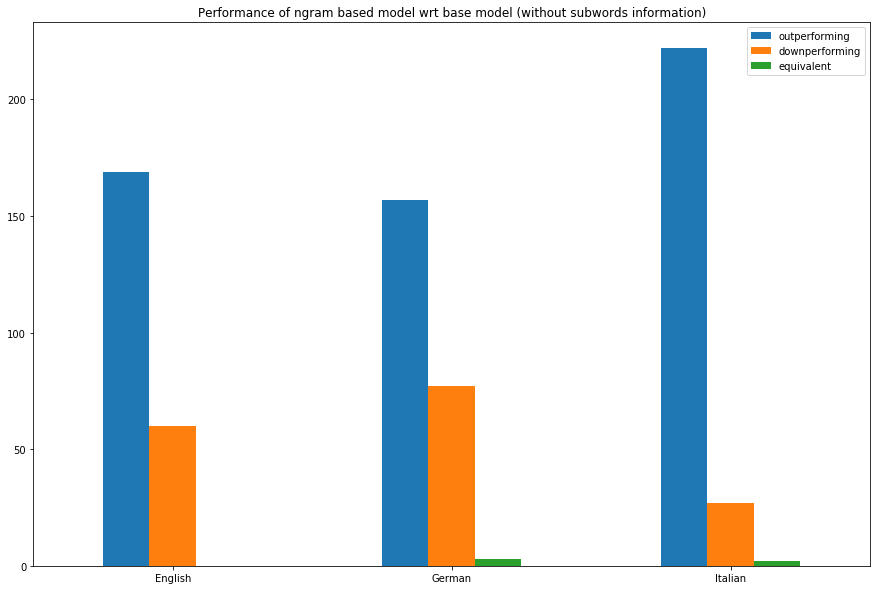

In [48]:
stats.plot(kind='bar', rot = 0, figsize=(15,10),
           title = 'Performance of ngram based model wrt base model (without subwords information)')

In [49]:
stats_v2 = pd.DataFrame.from_dict(ngram_stats_v2, orient = 'index')
stats_v2.index = ['English', 'German', 'Italian']
stats_v2

,outperforming,downperforming,equivalent
English,82,147,0
German,94,143,0
Italian,116,135,0


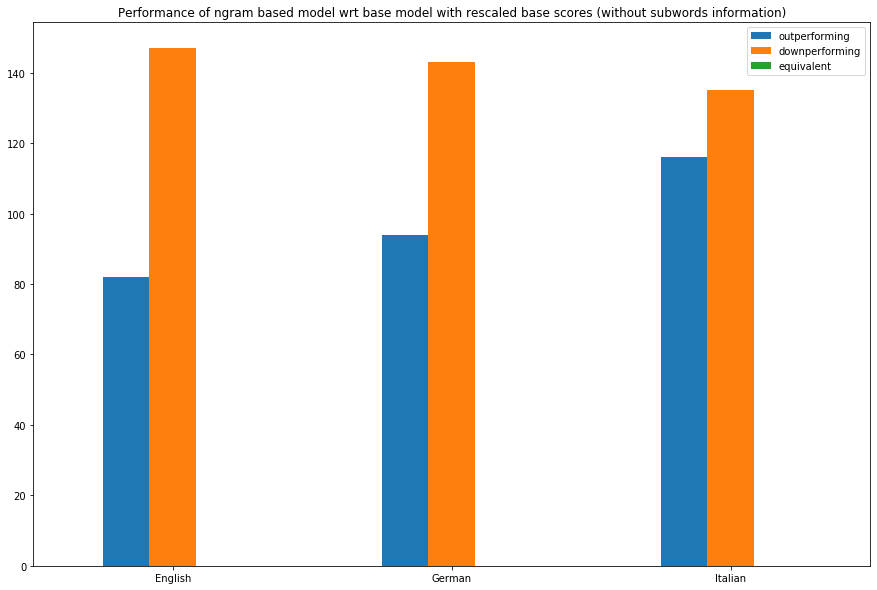

In [50]:
stats_v2.plot(kind='bar', rot = 0, figsize=(15,10),
           title = 'Performance of ngram based model wrt base model with rescaled base scores (without subwords information)')